# IBM Data Science Capstone Project - The best place to open a new pub

Github has problems displaying the folium maps correctly. Therefore, you can look at the notebook via this link:

https://nbviewer.jupyter.org/github/petrKantek/Coursera_Capstone/blob/main/Capstone-project.ipynb

## 1. Introduction
Everyone loves beer, there is not question about that. But due to the current pandemic situation, many pubs are endangered by the governmental restrictions. Limitations of pubs include: lowered capacity due to safety distance measures, reduced openning time, or in extreme cases closure. We can expect that many pubs will go bancrupt and will never reopen. This, on the other hand, provides an oppurtunity for brave entrepreneurs, who could open a new pub after the pandemic will have been vanished from the world, and thus fill the empty space in the pub and beer industry. We are here to help the potential pub-owners to choose the best location for their new pub! Since we already have some background knowledge of the Toronto area, we will focus on this location.

## 2. Data
We will use 2 data sources: 
1. Toronto neighbourhoods dataset
2. geocoordinates
3. Foursquare Database

We have already used the Toronto dataset in an earlier excercise. We will scrap it from a Wikipedia page using pandas functionality. It comprises of 3 columns: Postal Code, Borough, and Neighbourhood. The geocoordinates dataset will be loaded from a geojson file and contains longitude and latitude values for each postal code. Lastly, Foursquare database is a huge database containing lots of data about various places on the planet. We will need only information about venues. Each venue contains information such as: Name, Location, and Category. We will access the database via REST API, particulary by GET requests on the search endpoint.

Through out the notebook, we will preprocess those datasets and create many more intermediate ones. Lets begin. 

I prefer importing the libraries right at the firset place where I need them so I dont have to scroll the whole notebook up. Therefore, I will just important the base ones for every data science project and later will import the more specific ones.

In [1]:
import pandas as pd
import numpy as np
import requests
%matplotlib inline

### Loading neighbourhood data
Lets load the dataset with neighbourhoods and their related information from a wikipedia site.

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

df_hoods = pd.read_html( url )[0]
df_hoods

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


As we can see, all the columns have the same data type: object.

In [3]:
df_hoods.dtypes

Postal Code      object
Borough          object
Neighbourhood    object
dtype: object

We can see there are boroughs and neighbourhoods that have 'Not assigned' values. We will get rid of them.

In [4]:
df_hoods = df_hoods[ df_hoods[ 'Borough' ] != "Not assigned" ]
df_hoods

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Lets check we did it correctly and there are no 'Not assigned' values left both in Borough and Neighbourhood columns.

In [5]:
print( df_hoods[ df_hoods['Borough'] == "Not assigned" ].shape[0],
       df_hoods[ df_hoods['Neighbourhood'] == "Not assigned" ].shape[0]) 

0 0


Lastly, lets check the shape of the prepocessed dataset

In [6]:
df_hoods.shape

(103, 3)

Now we can group the dataframe by boroughs.

In [7]:
df_grouped = df_hoods.groupby( [ 'Borough', 'Postal Code' ], as_index = False ).agg( lambda x: ','.join( x ) )
df_grouped

,Borough,Postal Code,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"
...,...,...,...
98,York,M6C,Humewood-Cedarvale
99,York,M6E,Caledonia-Fairbanks
100,York,M6M,"Del Ray, Mount Dennis, Keelsdale and Silverthorn"
101,York,M6N,"Runnymede, The Junction North"


We can also see the number of neighbourhoods per each borough. 

In [8]:
grouped_boroughs = pd.DataFrame( df_hoods.groupby('Borough').count()['Neighbourhood'] )
grouped_boroughs

,Neighbourhood
Borough,
Central Toronto,9
Downtown Toronto,19
East Toronto,5
East York,5
Etobicoke,12
Mississauga,1
North York,24
Scarborough,17
West Toronto,6


We should also create some graphs, to better understand the dataset. Lets create a barplot of the number of neighbourhoods in each borough.

In [9]:
import seaborn as sns
sns.set()
%matplotlib inline

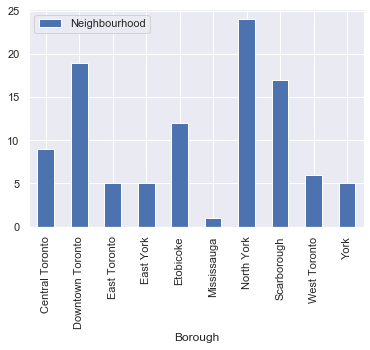

In [10]:
grouped_boroughs.plot( kind = "bar")

### Loading the geocoordinates

One of the options to get the geocoordinates would be via Geocoder API. But Since the API calls to get the geocoordinates are horribly slow and unstable, it is more efficient to load a csv file of already prepared data.

In [11]:
geocoords = pd.read_csv( "data/Geospatial_Coordinates.csv" )
geocoords

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


We can now merge the geocoordinates with the neighbourhood dataset on the *Postal Code* column.

In [12]:
df_toronto = pd.merge( df_grouped, geocoords, on = "Postal Code")
df_toronto.head()

,Borough,Postal Code,Neighbourhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


When we are dealing with the geocoordinates now, we can extract the coordinates of Toronto, that we will use later for creating a map.

In [13]:
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print(f'Toronto\'s coordinates: {lat_toronto}, {lon_toronto}')

Toronto's coordinates: 43.704607733980595, -79.3971529116505


### Loading Venue Data

We will get the venue data and, more importantly, pub data, from the Foursquare API. I have created a free account at the Foursquare's developer page. The following cell defines the authentication credentials needed to get any data from the API. 

In [14]:
CLIENT_ID = 'QZ4UPMNUKWW4WQHIARR1ZTA0AV15MPUQO5T3E2U3BW3XB10P' 
CLIENT_SECRET = 'JCWGSYS1GFLMQO4BTSUFG21ARQ2FPDX4JOMYMV1WMVIWLI5H'
VERSION = 20201013

Now we can load the venues data. I used a function that we had defined in one of the course excercises. The function makes a GET request to the API for each neighbourhood in the dataset. It gets a maximum of 100 venues per neighbourhood. 

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    LIMIT = 100 
    radius = 500
    venues_list = []
    for name, lat, lng in zip( names, latitudes, longitudes ):
        print( name )
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(names = df_toronto['Neighbourhood'], latitudes = df_toronto['Latitude'],
                                longitudes = df_toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [18]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop


In [19]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
...,...,...,...,...,...,...
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4
Woodbine Heights,7,7,7,7,7,7


Now we will explore the venue categories.

In [20]:
print( f"Number of unique categories: {len(toronto_venues['Venue Category'].unique())}")

Number of unique categories: 272


In [21]:
print(f"Categories of venues: {toronto_venues['Venue Category'].unique()}" )

Categories of venues: ['Park' 'Swim School' 'Bus Line' 'Breakfast Spot' 'Food & Drink Shop'
 'Department Store' 'Hotel' 'Sandwich Place' 'Gym / Fitness Center'
 'Dog Run' 'Dance Studio' 'Yoga Studio' 'Salon / Barbershop' 'Diner'
 'Coffee Shop' 'Restaurant' 'Spa' 'Chinese Restaurant'
 'Mexican Restaurant' 'Clothing Store' 'Fast Food Restaurant'
 'Sporting Goods Shop' 'Café' 'Ice Cream Shop' 'Furniture / Home Store'
 'Bagel Shop' 'Dessert Shop' 'Indian Restaurant' 'Italian Restaurant'
 'Pizza Place' 'Seafood Restaurant' 'Sushi Restaurant' 'Gym'
 'Thai Restaurant' 'Toy / Game Store' 'Brewery' 'Greek Restaurant'
 'Gas Station' 'Farmers Market' 'Gourmet Shop' 'Pharmacy'
 'Indoor Play Area' 'Trail' 'Playground' 'Liquor Store' 'Supermarket'
 'American Restaurant' 'Pub' 'Vietnamese Restaurant' 'Fried Chicken Joint'
 'Bank' 'Light Rail Station' 'Garden' 'Music Venue' 'Jewelry Store'
 'Donut Shop' 'Burger Joint' 'BBQ Joint' 'Middle Eastern Restaurant'
 'History Museum' 'Japanese Restaurant' 'Bak

We need to make sure, that venues we have loaded contain our desired category, Pub.

In [22]:
"Pub" in toronto_venues['Venue Category'].unique()

True

In order to train the machine learning model, we need to encode the venue categories. A one-hot encoding is suitable. The size of the one hot vectors is, of course the same as the number of categories.

In [23]:
onehot_enc = pd.get_dummies( toronto_venues[ ['Venue Category'] ], prefix = "", prefix_sep = "" )
onehot_enc[ 'Neighbourhoods' ] = toronto_venues[ 'Neighbourhood' ] 

fixed_columns = [ onehot_enc.columns[ -1 ] ] + list( onehot_enc.columns[ :-1 ] )
onehot_enc = onehot_enc[ fixed_columns ]

print(onehot_enc.shape)
onehot_enc

(2135, 273)


,Neighbourhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,"Runnymede, The Junction North",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2131,"Runnymede, The Junction North",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2132,"Runnymede, The Junction North",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2133,Weston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The average number of venues in a neighbourhood will serve as our clustering metric. 

In [24]:
to_grouped = onehot_enc.groupby(["Neighbourhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(96, 273)


,Neighbourhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
pubs = to_grouped[["Neighbourhoods","Pub"]]
pubs.head() 

,Neighbourhoods,Pub
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.142857
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.045455


In [26]:
pubs = pubs.rename(columns={'Neighbourhoods':'Neighbourhood'})

## 3. Methodology
In this section, we will finally train the machine learning model, particularly k-means clustering model, because we would like to cluster neighbourhoods that have similar potential for founding a new pub. There are many clustering algorithms, k-means, hierarchical clustering, DBSCAN, etc.. I will choose k-means as it is one of the most common one and we have already used it in previous exercises.

In [27]:
from sklearn.cluster import KMeans

Keep just the clustering metric.

In [28]:
X = pubs.drop(["Neighbourhood"], axis = 1)
X

,Pub
0,0.000000
1,0.142857
2,0.000000
3,0.000000
4,0.045455
...,...
91,0.000000
92,0.000000
93,0.000000
94,0.000000


As the evaluation metric for the best number of clusters, I have chosen *inertia* and the *elbow method*. The elbow method is commonly used for finding the optimal number of clusters.

In [29]:
def compute_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, random_state = 42 )
    km.fit(X)
    return km.inertia_

In [30]:
X = pubs.drop(['Neighbourhood'], axis=1)
scores = [compute_inertia(x) for x in range(2, 15)]

According to the *elbow method*, the best number of clusters is 5.

In [31]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Error')

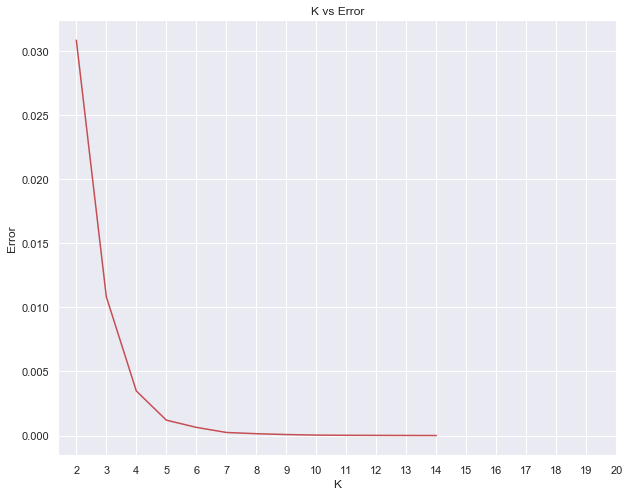

In [32]:
plt.figure(figsize = [10, 8])
sns.lineplot(x = range(2, 15), y = scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

Lets see the assigned labels to the neighbourhoods.

In [33]:
kmeans = KMeans(n_clusters = 5, random_state = 42 ).fit( X )
kmeans.labels_

array([0, 3, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 4, 0, 4, 0, 2, 2, 1, 4, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
to_merged = pubs.copy()
to_merged["Cluster Labels"] = kmeans.labels_

In [35]:
to_merged.head()

,Neighbourhood,Pub,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.142857,3
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.045455,2


Merge neighbourhoods, cluster labels, and their geoordinates all together so we can plot them on the map.

In [36]:
to_merged = to_merged.join(toronto_venues.set_index("Neighbourhood"), on = "Neighbourhood")

print(to_merged.shape)
to_merged.head()

(2135, 9)


,Neighbourhood,Pub,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.7942,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.7942,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.7942,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.7942,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
0,Agincourt,0.0,0,43.7942,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink


Lets see how many pubs are there in the clusters.

In [37]:
to_merged['Venue Category'].value_counts()["Pub"]

26

Finally we can plot a map of the resulting clusters using the *Folium* library.

In [38]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [39]:
map_clusters = folium.Map( location = [ lat_toronto, lon_toronto ], zoom_start = 11 )
kclusters = 5

x = np.arange(kclusters)
ys = [ i + x + (i * x) ** 2 for i in range( kclusters ) ]
colors_array = cm.rainbow( np.linspace( 0, 1, len( ys ) ) )
rainbow = [ colors.rgb2hex( i ) for i in colors_array ]

markers_colors = [ ]
for lat, lon, poi, cluster in zip( to_merged['Neighbourhood Latitude'], to_merged['Neighbourhood Longitude'], to_merged['Neighbourhood'], to_merged['Cluster Labels'] ):
    label = folium.Popup( str(poi) + ' - Cluster ' + str(cluster) )
    folium.CircleMarker(
        [ lat, lon ],
        radius = 5,
        popup = label,
        color = rainbow[ cluster - 1 ],
        fill_color = rainbow[ cluster - 1 ],
        fill_opacity = 0.8 ).add_to(map_clusters)
       
map_clusters

## 4. Results
We can look at what the clustering results are.

In [40]:
pubs["Cluster Labels"] = kmeans.labels_
pubs.head()

,Neighbourhood,Pub,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.142857,3
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.045455,2


We can plot the number of neighbours in each cluster.

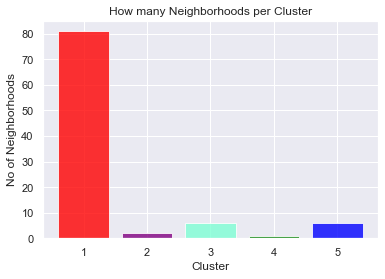

In [41]:
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
performance = pubs['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', "green", "blue" ])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

How many neighbourhoods in each cluster

In [42]:
pubs['Cluster Labels'].value_counts()

0    81
4     6
2     6
1     2
3     1
Name: Cluster Labels, dtype: int64

In [43]:
df_new = df_toronto[['Borough', 'Neighbourhood']]
df_new.head()

,Borough,Neighbourhood
0,Central Toronto,Lawrence Park
1,Central Toronto,Davisville North
2,Central Toronto,"North Toronto West, Lawrence Park"
3,Central Toronto,Davisville
4,Central Toronto,"Moore Park, Summerhill East"


### Examining data frames of the 5 clusters

In [44]:
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighbourhood')
print( f"Number of pubs in the first cluster: {df_cluster1['Venue Category'].value_counts(ascending = False)['Pub']}" )
df_cluster1

Number of pubs in the first cluster: 4


,Borough,Neighbourhood,Pub,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Central Toronto,Davisville North,0.0,0,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Central Toronto,Davisville North,0.0,0,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop
...,...,...,...,...,...,...,...,...,...,...
1684,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,195 Jane Rocket,43.672335,-79.492634,Bus Line
1685,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,High Park Brewery,43.669903,-79.483430,Brewery
1686,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,Starving Artist,43.669860,-79.483110,Breakfast Spot
1687,York,Weston,0.0,0,43.706876,-79.518188,Grattan Park,43.706222,-79.521705,Park


In [45]:
cluster2 = to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on = 'Neighbourhood')
df_cluster2.sort_values(["Pub"], ascending = False)
print( f"Number of pubs in the second cluster: {df_cluster2['Venue Category'].value_counts(ascending = False)['Pub']}" )
df_cluster2

Number of pubs in the second cluster: 2


,Borough,Neighbourhood,Pub,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,The Beaches,0.25,1,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,East Toronto,The Beaches,0.25,1,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,East Toronto,The Beaches,0.25,1,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,East Toronto,The Beaches,0.25,1,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,North York,Glencairn,0.25,1,43.709577,-79.445073,Miyako Sushi Restaurant,43.709111,-79.443930,Japanese Restaurant
5,North York,Glencairn,0.25,1,43.709577,-79.445073,"Chalker's Pub, Billiards and Bistro",43.705747,-79.442378,Pub
6,North York,Glencairn,0.25,1,43.709577,-79.445073,Domino's Pizza,43.707170,-79.442658,Pizza Place
7,North York,Glencairn,0.25,1,43.709577,-79.445073,Fraserwood Park,43.713550,-79.442482,Park


In [46]:
cluster3 = to_merged.loc[ to_merged[ 'Cluster Labels' ] == 2 ]
df_cluster3 = pd.merge( df_new, cluster3, on = 'Neighbourhood' )
print( f"Number of pubs in the third cluster: {df_cluster3['Venue Category'].value_counts(ascending = False)['Pub']}" )
df_cluster3

Number of pubs in the third cluster: 9


,Borough,Neighbourhood,Pub,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.071429,2,43.686412,-79.400049,LCBO,43.686991,-79.399238,Liquor Store
1,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.071429,2,43.686412,-79.400049,The Market By Longo’s,43.686711,-79.399536,Supermarket
2,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.071429,2,43.686412,-79.400049,Union Social Eatery,43.687895,-79.394916,American Restaurant
3,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.071429,2,43.686412,-79.400049,Daeco Sushi,43.687838,-79.395652,Sushi Restaurant
4,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.071429,2,43.686412,-79.400049,Mary Be Kitchen,43.687708,-79.395062,Restaurant
...,...,...,...,...,...,...,...,...,...,...
146,West Toronto,"Runnymede, Swansea",0.060606,2,43.651571,-79.484450,West End Mamas,43.648703,-79.484919,Health Food Store
147,West Toronto,"Runnymede, Swansea",0.060606,2,43.651571,-79.484450,My Place - a Canadian Pub,43.648458,-79.485187,Pub
148,West Toronto,"Runnymede, Swansea",0.060606,2,43.651571,-79.484450,(The New) Moksha Yoga Bloor West,43.648658,-79.485242,Yoga Studio
149,West Toronto,"Runnymede, Swansea",0.060606,2,43.651571,-79.484450,The Coffee Bouquets,43.648785,-79.485940,Coffee Shop


In [47]:
cluster4 = to_merged.loc[ to_merged[ 'Cluster Labels' ] == 3 ]
df_cluster4 = pd.merge( df_new, cluster4, on = 'Neighbourhood' )
print( f"Number of pubs in the fourth cluster: {df_cluster4['Venue Category'].value_counts(ascending = False)['Pub']}" )
df_cluster4

Number of pubs in the fourth cluster: 1


,Borough,Neighbourhood,Pub,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Etobicoke,"Alderwood, Long Branch",0.142857,3,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place
1,Etobicoke,"Alderwood, Long Branch",0.142857,3,43.602414,-79.543484,Timothy's Pub,43.600165,-79.544699,Pub
2,Etobicoke,"Alderwood, Long Branch",0.142857,3,43.602414,-79.543484,Toronto Gymnastics International,43.599832,-79.542924,Gym
3,Etobicoke,"Alderwood, Long Branch",0.142857,3,43.602414,-79.543484,Tim Hortons,43.602396,-79.545048,Coffee Shop
4,Etobicoke,"Alderwood, Long Branch",0.142857,3,43.602414,-79.543484,Pizza Pizza,43.605340,-79.547252,Pizza Place
5,Etobicoke,"Alderwood, Long Branch",0.142857,3,43.602414,-79.543484,Subway,43.599152,-79.544395,Sandwich Place
6,Etobicoke,"Alderwood, Long Branch",0.142857,3,43.602414,-79.543484,Rexall,43.601951,-79.545694,Pharmacy


In [48]:
cluster5 = to_merged.loc[ to_merged[ 'Cluster Labels' ] == 4 ]
df_cluster5 = pd.merge( df_new, cluster5, on = 'Neighbourhood' )
print( f"Number of pubs in the fifth cluster: {df_cluster5['Venue Category'].value_counts(ascending = False)['Pub']}" )
df_cluster5

Number of pubs in the fifth cluster: 10


,Borough,Neighbourhood,Pub,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"St. James Town, Cabbagetown",0.041667,4,43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner
1,Downtown Toronto,"St. James Town, Cabbagetown",0.041667,4,43.667967,-79.367675,Kingyo Toronto,43.665895,-79.368415,Japanese Restaurant
2,Downtown Toronto,"St. James Town, Cabbagetown",0.041667,4,43.667967,-79.367675,Butter Chicken Factory,43.667072,-79.369184,Indian Restaurant
3,Downtown Toronto,"St. James Town, Cabbagetown",0.041667,4,43.667967,-79.367675,Murgatroid,43.667381,-79.369311,Restaurant
4,Downtown Toronto,"St. James Town, Cabbagetown",0.041667,4,43.667967,-79.367675,F'Amelia,43.667536,-79.368613,Italian Restaurant
...,...,...,...,...,...,...,...,...,...,...
346,East Toronto,"The Danforth West, Riverdale",0.023256,4,43.679557,-79.352188,Second Cup,43.677232,-79.352898,Coffee Shop
347,East Toronto,"The Danforth West, Riverdale",0.023256,4,43.679557,-79.352188,Kitchen Stuff Plus,43.678613,-79.346422,Furniture / Home Store
348,East Toronto,"The Danforth West, Riverdale",0.023256,4,43.679557,-79.352188,LCBO,43.676816,-79.356047,Liquor Store
349,East Toronto,"The Danforth West, Riverdale",0.023256,4,43.679557,-79.352188,Katsu Japanese Restaurant,43.678619,-79.347024,Sushi Restaurant


Some final resulting graph, the average number of pubs per cluster. It is easy to see, that the highest average belongs to the 3. cluster, which is caused by the small number of neighbourhoods compared to the other clusters.

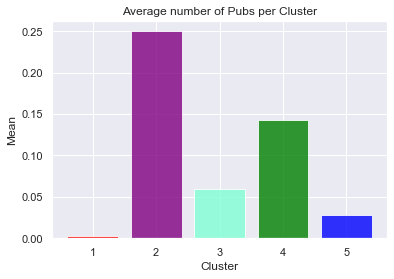

In [49]:
clusters_mean = [df_cluster1['Pub'].mean(),df_cluster2['Pub'].mean(),df_cluster3['Pub'].mean(),df_cluster4['Pub'].mean(),df_cluster5['Pub'].mean()
                 ]
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', "green", "blue"])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Pubs per Cluster')

plt.show()

## 5. Discussion and Conclusion

We have gone through the whole machine learning(or data science) pipiline; from data loading and wrangling, to exploration, model training, optimization, and assessing the results. In the end there were 5 clusters, that k-means algorithm created. As per the initial task, to find the optimal place to set up a new pub, we can sketch a few answers. I would definitely not recommend to set up a pub in the any of the neighbourhoods in the 2. or 4. cluster, as the average number of pubs in them is too large and the number of neighbourhoods too small, which means, that the competition could be too large and setting a pub there would be inneficient. As for the other three clusters, those look more promising, with clusters 3 and 5 being close to each other both in term of the average number of pubs and the number of neighbourhoods. The most pormising one seems to be the 1. cluster, as its average number of pubs is tiny and the number of neighbourshoods big. So tu sum up, for further consideration of other facts and conditions I would recommend looking at pub places in the neighbourhoods of the 1. or 5. clusters. :)

One of the drawbacks of this analysis could be the concern, that the data from the Foursquare database do not reliably represent the current situation in Toronto.  